In [14]:
import igraph as ig
import numpy as np
from numpy.linalg import norm
import random
import pandas as pd
import scipy.io
import time
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from IPython.display import display, clear_output
from operator import itemgetter
from sklearn.decomposition import PCA
from SOINN import SF_SOINN

## Auxiliary functions

In [15]:
def train_phase(model, data, labels):
    """
    Training phase where data is fitted into the model.

    Parameters
    ----------
    model : SF_SOINN network
        The network to train.
    data : dataframe
        Input dataset with normalized features.
    labels : array, shape=[n_examples]
        Labels associated to the examples in the input dataset.

    Returns
    -------
    xs : list
        List of x values (for plotting).
    n_nodes : list
        List that containes the number of nodes for each xs (for plotting).
    n_edges : list
        List that containes the number of edges for each xs (for plotting).
    n_del_nodes : list
        List that containes the number of deleted nodes for each xs (for plotting).
    n_del_edges : list
        List that containes the number of deleted edges for each xs (for plotting).
    """
    # for plotting
    xs = []
    n_nodes = []
    n_edges = []
    n_del_nodes = []
    n_del_edges = []

    start_time = time.time()

    for index, row in data.iterrows():
        model.input_signal(x=row.values, y=labels[index], learning=True)

        # print completed percentage
        percent_completed = round((index / len(data))*100, 2)
        if index % 100 == 0 or index == len(data):
            clear_output(wait=True)
            print(f'Processing input {index}: {percent_completed}% completed')
            # for plotting
            n_nodes.append(model.network.vcount())
            n_edges.append(model.network.ecount())
            n_del_nodes.append(model.n_del_nodes)
            n_del_edges.append(model.n_del_edges)
            xs.append(index)

    finish_time = round(time.time() - start_time)
    mins = round(finish_time / 60)
    secs = finish_time % 60
    clear_output(wait=True)
    print(f'Training time: {mins} min {secs} sec')
    print(f'Inputs processed: {index}')

    print(f'Number of nodes: {model.network.vcount()}')
    print(f'Number of edges: {model.network.ecount()}')

    return xs, n_nodes, n_edges, n_del_nodes, n_del_edges

In [16]:
def update_phase(model, data, labels, show_stats=True):
    """
    Update phase where predictions are made, and the wrong ones get fed back. Outputs the performance metrics.

    Parameters
    ----------
    model : SF_SOINN network
        The network to train.
    data : dataframe
        Input dataset with normalized features.
    labels : array, shape=[n_examples]
        Labels associated to the examples in the input dataset.
    show_stats : boolean (default: True)
        If True, show statistics and performance metrics.
    """
    predicted = []
    # Positive = is an attack
    # Negative = normal connection

    # True Positives (TP): number of correctly predicted attacks
    tp = 0
    # False Negatives (FN): anomalies classified as normal
    fn = 0
    # False Positives (FP): normal connections classified as anomalies
    fp = 0
    # True Negatives (TN): number of correctly predicted normal connections
    tn = 0

    # evaluation metrics

    # True Positive Rate (TPR) or Detection Rate (DR): ratio between the number of correctly predicted attacks and the total number of attacks, also called Detection Rate (DR)
    # TPR = TP / (TP + FN)
    tpr = 1
    # False Positive Rate (FPR): ratio between the number of normal instances incorrectly classified as attacks and the total number of normal instances
    # FPR = FP / (FP + TN)
    fpr = 1
    # False Negative Rate (FNR): failed to identify an anomaly and classified as normal
    # FNR = FN / (FN + TP)
    fnr = 1
    # Positive Predictive Value (PPV): chance of intrusion detected if an alarm is issued by the IDS
    # PPV = TP / (TP + FP)
    ppv = 1
    # Negative Predictive Value (NPV): chance that there is no intrusion when IDS does not output an alarm
    # NPV = TN / (TN + FN)
    npv = 1
    # Classification Rate (CR) or Accuracy: percentage of all those correctly predicted instances to all instances, also known as Accuracy
    # CR = (TP + TN) / (TP + TN + FP + FN)
    accuracy = 1
    # Base Rate (B): probability of input being an attack
    # B = (TP + FN) / (TP + TN + FP + FN)
    b = 1
    # Intrusion Detection Capability (CID): ratio of the mutual information between input and output and the entropy of the input
    # CID = (H(X) - H(X | Y)) / H(X)
    cid = 1

    start_time = time.time()

    for index, row in data.iterrows():
        x = row.values
        y = labels[index]
        # predicted label
        yp, _ = model.input_signal(x=x, learning=False)
        predicted.append(yp)

        # feedback loop
        if y != yp:
            model.input_signal(x=x, y=y, learning=True)

        # true positive count
        if yp != 'normal' and y != 'normal':
            tp += 1
        # false positive count
        if yp != 'normal' and y == 'normal':
            fp += 1
        # true negatives count
        if yp == 'normal' and y == 'normal':
            tn += 1
        # false negative count
        if yp == 'normal' and y != 'normal':
            fn += 1

        # print completed percentage
        percent_completed = round((index / len(data))*100, 2)
        if index % 100 == 0 or index == len(data):
            clear_output(wait=True)
            print(f'Predictions completed: {percent_completed}%')
            
    clear_output(wait=True)
    if show_stats:
        finish_time = round(time.time() - start_time)
        mins = round(finish_time / 60)
        secs = finish_time % 60

        # metrics computation
        if (tp + fn) > 0:
            tpr = tp / (tp + fn)
        if (fp + tn) > 0:
            fpr = fp / (fp + tn)
        if (fn + tp) > 0:
            fnr = fn / (fn + tp)
        if (tp + fp) > 0:
            ppv = tp / (tp + fp)
        if (tn + fn) > 0:
            npv = tn / (tn + fn)
        if (tp + tn + fp + fn) > 0:
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            b = (tp + fn) / (tp + tn + fp + fn)
        # entropy H(X)
        if b > 0 and (1-b) > 0:
            h_x = -b * math.log(b) - (1-b) * math.log(1-b)
        else:
            h_x = 0
        # entropy H(X | Y)
        # formula is a bit complicated, reference thesis for it
        # two equal versions for entropy
        # this version uses ppv and npv values
        #h_x_y = -b * (1-fnr) * math.log(ppv) - b * fnr * math.log(1 - npv) - (1-b) * (1-fpr) * math.log(npv) - (1-b) * fpr * math.log(1-ppv)
        # this version does not use ppv and npv
        if (b * (1 - fnr) + (1 - b) * fpr) != 0 and (b * (1 - fnr) / (b * (1 - fnr) + (1 - b) * fpr)):
            h_x_y = -b * (1 - fnr) * math.log(b * (1 - fnr) / (b * (1 - fnr) + (1 - b) * fpr))
        else:
            h_x_y = 0
        if (b * fnr + (1 - b) * (1-fpr)) != 0 and (b * fnr / (b * fnr + (1 - b) * (1-fpr))) > 0:
            h_x_y -= b * fnr * math.log( b * fnr / (b * fnr + (1 - b) * (1-fpr)) )
        else:
            h_x_y -= 0
        if ((1 - b) * (1 - fpr) + b * fnr) != 0 and ((1 - b) * (1 - fpr) / ((1 - b) * (1 - fpr) + b * fnr)) > 0:
            h_x_y -= (1 - b) * (1 - fpr) * math.log( (1 - b) * (1 - fpr) / ((1 - b) * (1 - fpr) + b * fnr) )
        else:
            h_x_y -= 0
        if ((1 - b) * fpr + b * (1 - fnr)) != 0 and ((1 - b) * fpr / ((1 - b) * fpr + b * (1 - fnr))) > 0:
            h_x_y -= (1 - b) * fpr * math.log( (1 - b) * fpr / ((1 - b) * fpr + b * (1 - fnr)) )
        else:
            h_x_y -= 0

        if h_x == 0 or h_x == 1:
            cid = 1
        else:
            cid = (h_x - h_x_y) / h_x

        clear_output(wait=True)
        print(f'Update phase time: {mins} min {secs} sec')
        print(f'Inputs processed: {index}')

        print(f'Accuracy (percentage of correctly predicted instances): {round(accuracy * 100, 2)}%')
        print(f'Detection Rate (TPR): {round(tpr * 100, 2)}%')
        print(f'False Positive Rate (FPR - normal classified as attacks): {round(fpr * 100, 2)}%')
        print(f'False Negatives Rate (FNR - attacks classified as normal): {round(fnr * 100, 2)}%')
        print(f'Intrusion Detection Capability (CID): {round(cid * 100, 2)}%')

        # creating a frequency dict for visualizing the attacks with the most mistakes
        errors_freq = dict()
        for i in range(len(labels)):
            if labels[i] != predicted[i]:
                errors_freq[f'{labels[i]}-{predicted[i]}'] = 0
        for i in range(len(labels)):
            if labels[i] != predicted[i]:
                errors_freq[f'{labels[i]}-{predicted[i]}'] += 1
        # sort frequency dictionary
        errors_freq = dict(sorted(errors_freq.items(), key=itemgetter(1), reverse=True))
        print('\n\n')
        print(errors_freq)

In [17]:
def live_phase(model, connection, teach=False, label=None):
    """
    Live phase, where connections are fit into the model. Can work in teaching mode.

    Parameters
    ----------
    model : SF_SOINN network
        The model network.
    connection : array, shape=[n_features]
        Unlabeled input example.
    teach : boolean (default: False)
        If True, then the input is used to train the model.
    label : string (default: None)
        Label associated to the input example.
    """
    # connection has no associated label
    if teach:
        if label is None:
            yp, confidence = model.input_signal(x=connection, learning=True)
        else:
            yp, confidence = model.input_signal(x=connection, y=label, learning=True)
    else:
        yp, confidence = model.input_signal(x=connection, learning=False)
    return yp, confidence

# Dataset importing

- `train`: the full training dataset
- `test`: the full testing dataset
- `test_21`: a subset of the full testing dataset in which only connections with difficulty level of '21' are taken, these are the 'easiest' connections to classify
- `test_n21`: most difficult testing dataset, with an extended set of attacks not present in the train data

Then, the `train` is divided into subsets for each attack macro-class, namely `NORMAL`, `R2L`, `U2R`, `DOS`, and `PROBING`.

In [18]:
train = pd.read_csv('./NSL-KDD/KDDTrain+.txt', sep=',', header=None)
test = pd.read_csv('./NSL-KDD/KDDTest+.txt', sep=',', header=None)
test_n21 = pd.read_csv('./NSL-KDD/KDDTest-21.txt', sep=',', header=None)

# dropping first not necessary column
train.drop([0], axis=1, inplace=True)
test.drop([0], axis=1, inplace=True)
test_n21.drop([0], axis=1, inplace=True)

# shuffling training dataset
train = train.sample(frac=1).reset_index(drop=True)

# one-hot encoding for non-ordinal categorical variables (first three columns)
train = pd.get_dummies(train, columns=[1, 2, 3])
test = pd.get_dummies(test, columns=[1, 2, 3])
test_n21 = pd.get_dummies(test_n21, columns=[1, 2, 3])

# adding columns present in train but not in test
extra_columns = []
for i in train.columns.values:
    if i not in test.columns.values:
        extra_columns.append(i)
for col in extra_columns:
    test[col] = 0
extra_columns = []
for i in train.columns.values:
    if i not in test_n21.columns.values:
        extra_columns.append(i)
for col in extra_columns:
    test_n21[col] = 0

# reordering columns
train.columns.astype('string')
test.columns.astype('string')
test_n21.columns.astype('string')
cols = train.columns.tolist()
cols.sort()
train = train[cols]
test = test[cols]
test_n21 = test_n21[cols]

# selecting subset of difficulty < 21 for test dataset
test_21 = test[test['42'] == 21]
test_21.reset_index(inplace=True)
del test_21['42']
del test_21['index']

# dropping the 'difficulty level' column
del train['42']
del test['42']
del test_n21['42']

## Create train and test datasets for each attack macro-category

In [19]:
# sets to filter attack types
dos_attacks = {'back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'apache2', 'mailbomb', 'processtable', 'snmpgetattack', 'udpstorm'}
r2l_attacks = {'ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster', 'snmpguess', 'multihop', 'named', 'sendmail', 'xlock', 'xsnoop', 'worm'}
u2r_attacks = {'buffer_overflow', 'perl', 'loadmodule', 'rootkit', 'ps', 'xterm', 'sqlattack', 'httptunnel'}
probing_attacks = {'ipsweep', 'nmap', 'portsweep', 'satan', 'mscan', 'saint', 'worm'}

train_normal = train[train['41'] == 'normal']
train_dos = train[train['41'].isin(dos_attacks)]
train_r2l = train[train['41'].isin(r2l_attacks)]
train_u2r = train[train['41'].isin(u2r_attacks)]
train_probing = train[train['41'].isin(probing_attacks)]

test_normal = test[test['41'] == 'normal']
test_dos = test[test['41'].isin(dos_attacks)]
test_r2l = test[test['41'].isin(r2l_attacks)]
test_u2r = test[test['41'].isin(u2r_attacks)]
test_probing = test[test['41'].isin(probing_attacks)]

## Removing class labels and obtaining labels lists

In [20]:
# dropping label
y_train = train['41'].values
del train['41']
y_test = test['41'].values
del test['41']
y_test_21 = test_21['41'].values
del test_21['41']
y_test_n21 = test_n21['41'].values
del test_n21['41']

y_train_normal = train_normal['41'].values
del train_normal['41']
y_train_dos = train_dos['41'].values
del train_dos['41']
y_train_r2l = train_r2l['41'].values
del train_r2l['41']
y_train_u2r = train_u2r['41'].values
del train_u2r['41']
y_train_probing = train_probing['41'].values
del train_probing['41']

y_test_normal = test_normal['41'].values
del test_normal['41']
y_test_dos = test_dos['41'].values
del test_dos['41']
y_test_r2l = test_r2l['41'].values
del test_r2l['41']
y_test_u2r = test_u2r['41'].values
del test_u2r['41']
y_test_probing = test_probing['41'].values
del test_probing['41']

## Features Normalization in $[0, 1]$

In [8]:
# features normalization
mms = MinMaxScaler()
train[train.columns] = mms.fit_transform(train)
test[test.columns] = mms.transform(test)
test_n21[test_n21.columns] = mms.transform(test_n21)
test_21[test_21.columns] = mms.transform(test_21)

train_normal[train_normal.columns] = mms.transform(train_normal)
train_dos[train_dos.columns] = mms.transform(train_dos)
train_r2l[train_r2l.columns] = mms.transform(train_r2l)
train_u2r[train_u2r.columns] = mms.transform(train_u2r)
train_probing[train_probing.columns] = mms.transform(train_probing)

test_normal[test_normal.columns] = mms.transform(test_normal)
test_dos[test_dos.columns] = mms.transform(test_dos)
test_r2l[test_r2l.columns] = mms.transform(test_r2l)
test_u2r[test_u2r.columns] = mms.transform(test_u2r)
test_probing[test_probing.columns] = mms.transform(test_probing)

<ipython-input-8-48d8fc508b16>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_21[test_21.columns] = mms.transform(test_21)
C:\Users\marti\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-8-48d8fc508b16>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

## Divide train dataset into incremental subsets

`train` contains 125973 examples

In [9]:
# main incremental sets
train_1 = train[:10000]
train_2 = train[10000:20000]
train_3 = train[20000:30000]
train_4 = train[30000:40000]
train_5 = train[40000:50000]
train_6 = train[50000:60000]
train_7 = train[60000:70000]
train_8 = train[70000:80000]
train_9 = train[80000:90000]
train_10 = train[90000:100000]
train_11 = train[100000:110000]
train_12 = train[110000:120000]
train_13 = train[120000:]

y_train_1 = y_train[:10000]
y_train_2 = y_train[10000:20000]
y_train_3 = y_train[20000:30000]
y_train_4 = y_train[30000:40000]
y_train_5 = y_train[40000:50000]
y_train_6 = y_train[50000:60000]
y_train_7 = y_train[60000:70000]
y_train_8 = y_train[70000:80000]
y_train_9 = y_train[80000:90000]
y_train_10 = y_train[90000:100000]
y_train_11 = y_train[100000:110000]
y_train_12 = y_train[110000:120000]
y_train_13 = y_train[120000:]

## Resetting indexes

In [10]:
train_2.reset_index(inplace=True)
train_3.reset_index(inplace=True)
train_4.reset_index(inplace=True)
train_5.reset_index(inplace=True)
train_6.reset_index(inplace=True)
train_7.reset_index(inplace=True)
train_8.reset_index(inplace=True)
train_9.reset_index(inplace=True)
train_10.reset_index(inplace=True)
train_11.reset_index(inplace=True)
train_12.reset_index(inplace=True)
train_13.reset_index(inplace=True)

del train_2['index']
del train_3['index']
del train_4['index']
del train_5['index']
del train_6['index']
del train_7['index']
del train_8['index']
del train_9['index']
del train_10['index']
del train_11['index']
del train_12['index']
del train_13['index']

train_normal.reset_index(inplace=True)
train_dos.reset_index(inplace=True)
train_r2l.reset_index(inplace=True)
train_u2r.reset_index(inplace=True)
train_probing.reset_index(inplace=True)

test_normal.reset_index(inplace=True)
test_dos.reset_index(inplace=True)
test_r2l.reset_index(inplace=True)
test_u2r.reset_index(inplace=True)
test_probing.reset_index(inplace=True)

del train_normal['index']
del train_dos['index']
del train_r2l['index']
del train_u2r['index']
del train_probing['index']

del test_normal['index']
del test_dos['index']
del test_r2l['index']
del test_u2r['index']
del test_probing['index']

## Attacks inspection

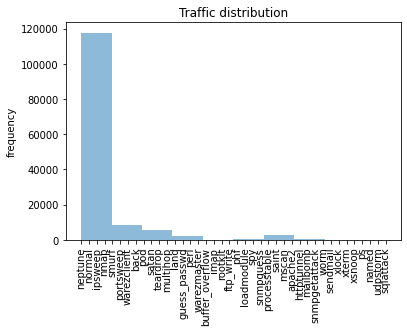

In [11]:
plt.title('Traffic distribution')
plt.ylabel('frequency')
plt.xticks(rotation=90)
plt.hist(np.append(y_train, y_test_n21), alpha=0.5, histtype='bar')
plt.show()

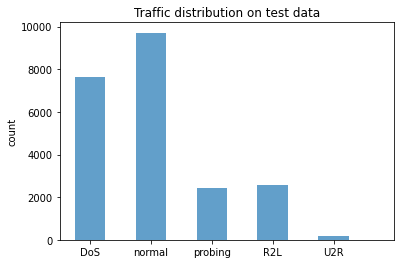

In [12]:
freq = []

for y in y_test:
    if y in dos_attacks:
        freq += ['DoS']
    if y == 'normal':
        freq += ['normal']
    if y in probing_attacks:
        freq += ['probing']
    if y in r2l_attacks:
        freq += ['R2L']
    if y in u2r_attacks:
        freq += ['U2R']

plt.title('Traffic distribution on test data')
plt.ylabel('count')
plt.hist(freq, alpha=0.7, histtype='bar', bins=np.arange(6)-0.25, width=0.5)
plt.show()
#plt.savefig('./test_traffic_dist.png')

In [13]:
n_attack = 0
n_normal = 0
attack_types = set()

for c in np.append(y_train, y_test_n21):
    if c == 'normal':
        n_normal += 1
    else:
        attack_types.add(c)
        n_attack += 1

print(f'Attack traffic: {n_attack} connections')
print(f'Normal traffic: {n_normal} connections')
print(f'Attack types: {len(attack_types)}')

Attack traffic: 68328 connections
Normal traffic: 69495 connections
Attack types: 39


# SF-SOINN Testing

## Test #1: train on `train` and test on `test`, `test_n21`, and `test_21`

In [21]:
rand_int = random.randint(1, len(train) - 1)
x1 = train.iloc[rand_int].values
rand_int = random.randint(1, len(train) - 1)
x2 = train.iloc[rand_int].values
rand_int = random.randint(1, len(train) - 1)
x3 = train.iloc[rand_int].values

s = SF_SOINN.SF_SOINN(x1, x2, x3, max_edge_age=100, iter_lambda=100)

xs, n_nodes, n_edges, n_del_nodes, n_del_edges = train_phase(model=s, data=train, labels=y_train)

Training time: 6 min 39 sec
Inputs processed: 125972
Number of nodes: 476
Number of edges: 1557


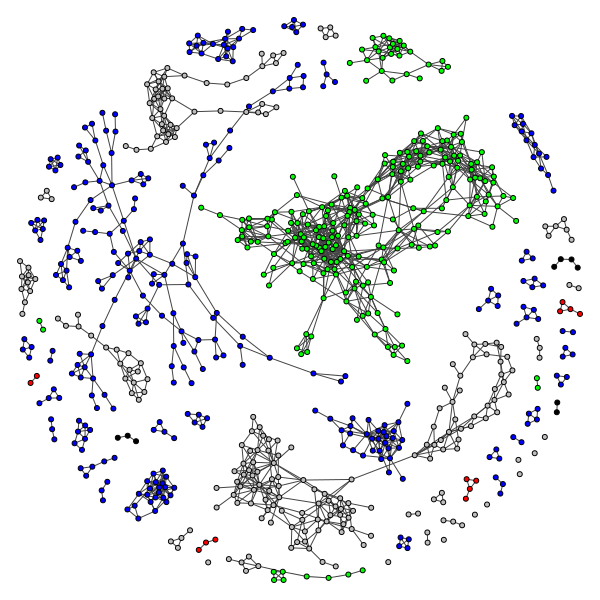

In [41]:
i = 0
color_dict = dict()
classes = np.unique(np.append(y_train, y_test))
palette = ig.ClusterColoringPalette(len(classes))
for c in classes:
    if c == 'normal':
        color_dict[c] = 'green'
    if c in dos_attacks:
        color_dict[c] = 'blue'
    if c in r2l_attacks:
        color_dict[c] = 'red'
    if c in u2r_attacks:
        color_dict[c] = 'black'
    if c in probing_attacks:
        color_dict[c] = 'grey'
    #color_dict[c] = palette[i]
    i += 1

# for saving as PNG
#ig.plot(s.network, 'network.png', vertex_size=5, vertex_color=[color_dict[c] for c in s.network.vs['c']])
ig.plot(s.network, vertex_size=5, vertex_color=[color_dict[c] for c in s.network.vs['c']])

In [30]:
# create a legend image to include in the previous picture using editing tools (adding legend is not supported by igraph)
from PIL import Image, ImageDraw, ImageFont

legend = Image.new("RGBA", (100, 150), (255,255,255,0))
d = ImageDraw.Draw(legend)

# setting font
fnt = ImageFont.truetype('Gidole-Regular.ttf', 20)

# normal - green
shape = [(0, 7), (10, 17)]
d.rectangle(shape, fill='#00ff00', outline="black")
d.text((20, 0), 'normal', font=fnt, fill=(0,0,0,255))
# DOS - blue
shape = [(0, 27), (10, 37)]
d.rectangle(shape, fill='#0000ff', outline="black")
d.text((20, 22), 'DOS', font=fnt, fill=(0,0,0,255))
# R2L - red
shape = [(0, 47), (10, 57)]
d.rectangle(shape, fill='#ff0000', outline="black")
d.text((20, 42), 'R2L', font=fnt, fill=(0,0,0,255))
# U2R - black
shape = [(0, 67), (10, 77)]
d.rectangle(shape, fill='#000000', outline="black")
d.text((20, 62), 'U2R', font=fnt, fill=(0,0,0,255))
# probing - grey
shape = [(0, 87), (10, 97)]
d.rectangle(shape, fill='#808080', outline="black")
d.text((20, 80), 'probing', font=fnt, fill=(0,0,0,255))

legend.show()
#legend.save('legend.png')

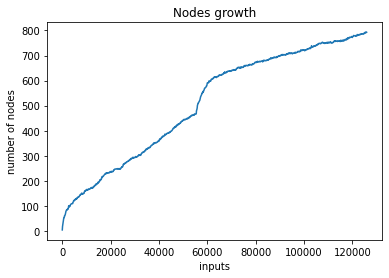

In [15]:
plt.plot(xs, n_nodes)
plt.title('Nodes growth')
plt.xlabel('inputs')
plt.ylabel('number of nodes')
#plt.savefig('./nodes_growth.png')
plt.show()

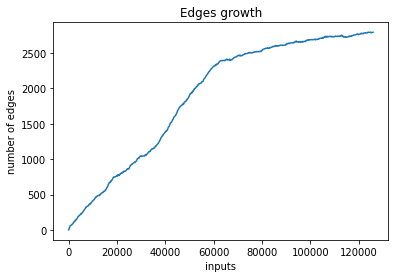

In [16]:
plt.plot(xs, n_edges)
plt.title('Edges growth')
plt.xlabel('inputs')
plt.ylabel('number of edges')
#plt.savefig('./edges_growth.png')
plt.show()

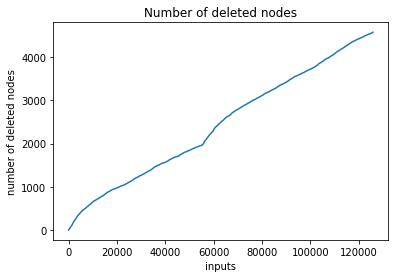

In [17]:
plt.plot(xs, n_del_nodes)
plt.title('Number of deleted nodes')
plt.xlabel('inputs')
plt.ylabel('number of deleted nodes')
#plt.savefig('./nodes_del.png')
plt.show()

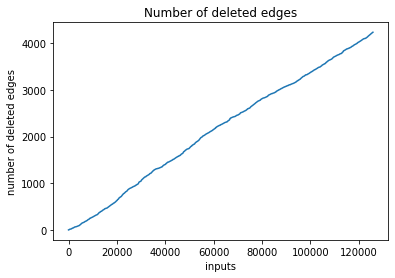

In [18]:
plt.plot(xs, n_del_edges)
plt.title('Number of deleted edges')
plt.xlabel('inputs')
plt.ylabel('number of deleted edges')
#plt.savefig('./edges_del.png')
plt.show()

There are 39 attack types including the ones in the `test_n21` dataset

In [19]:
vc = s.network.components()
gc = vc.cluster_graph()

print(f'Number of clusters: {gc.vcount()}')

Number of clusters: 24


In [20]:
update_phase(model=s, data=test, labels=y_test)

Update phase time: 3 min 34 sec
Inputs processed: 22543
Accuracy (percentage of correctly predicted instances): 92.83%
Detection Rate (TPR): 93.62%
False Positive Rate (FPR - normal classified as attacks): 8.22%
False Negatives Rate (FNR - attacks classified as normal): 6.38%
Intrusion Detection Capability (CID): 62.37%



{'satan-saint': 175, 'warezmaster-normal': 155, 'normal-back': 136, 'normal-warezmaster': 135, 'snmpguess-normal': 128, 'normal-mailbomb': 128, 'saint-satan': 115, 'back-normal': 92, 'mailbomb-normal': 92, 'normal-satan': 88, 'processtable-guess_passwd': 80, 'normal-snmpguess': 78, 'guess_passwd-processtable': 74, 'snmpgetattack-normal': 68, 'mscan-neptune': 66, 'snmpgetattack-snmpguess': 54, 'satan-normal': 49, 'normal-snmpgetattack': 48, 'warezmaster-guess_passwd': 44, 'guess_passwd-normal': 41, 'apache2-back': 39, 'snmpguess-snmpgetattack': 37, 'back-apache2': 35, 'guess_passwd-warezmaster': 34, 'saint-nmap': 30, 'mscan-httptunnel': 28, 'mscan-normal': 26, 'neptun

In [21]:
update_phase(model=s, data=test_n21, labels=y_test_n21)

Update phase time: 1 min 29 sec
Inputs processed: 11849
Accuracy (percentage of correctly predicted instances): 91.04%
Detection Rate (TPR): 93.9%
False Positive Rate (FPR - normal classified as attacks): 21.84%
False Negatives Rate (FNR - attacks classified as normal): 6.1%
Intrusion Detection Capability (CID): 43.38%



{'satan-saint': 165, 'snmpguess-normal': 112, 'saint-satan': 109, 'warezmaster-normal': 104, 'normal-warezmaster': 82, 'normal-snmpguess': 79, 'normal-satan': 73, 'satan-normal': 67, 'snmpgetattack-normal': 64, 'mscan-neptune': 51, 'normal-back': 43, 'mailbomb-normal': 39, 'normal-snmpgetattack': 37, 'snmpgetattack-snmpguess': 37, 'snmpguess-snmpgetattack': 35, 'guess_passwd-processtable': 34, 'neptune-mscan': 34, 'normal-mailbomb': 31, 'processtable-guess_passwd': 30, 'apache2-back': 27, 'back-normal': 26, 'back-apache2': 23, 'mscan-processtable': 22, 'apache2-normal': 20, 'portsweep-normal': 20, 'satan-portsweep': 20, 'neptune-normal': 20, 'normal-guess_passwd': 19,

In [24]:
update_phase(model=s, data=test_21, labels=y_test_21)

Update phase time: 1 min 8 sec
Inputs processed: 10693
Accuracy (percentage of correctly predicted instances): 99.64%
Detection Rate (TPR): 100.0%
False Positive Rate (FPR - normal classified as attacks): 0.52%
False Negatives Rate (FNR - attacks classified as normal): 0.0%
Intrusion Detection Capability (CID): 96.75%



{'normal-warezmaster': 13, 'normal-smurf': 13, 'saint-satan': 6, 'normal-multihop': 4, 'normal-guess_passwd': 3, 'normal-named': 3, 'normal-snmpgetattack': 2, 'normal-ipsweep': 1, 'saint-neptune': 1, 'neptune-satan': 1}


## Test #2: initial training on the `test`, then incremental training datasets from 1 to 13 (Constantinides)

In [12]:
rand_int = random.randint(1, len(test) - 1)
x1 = test.iloc[rand_int].values
rand_int = random.randint(1, len(test) - 1)
x2 = test.iloc[rand_int].values
rand_int = random.randint(1, len(test) - 1)
x3 = test.iloc[rand_int].values

s = SF_SOINN.SF_SOINN(x1, x2, x3, max_edge_age=100, iter_lambda=100)

_, _, _, _, _ = train_phase(model=s, data=test, labels=y_test)

Training time: 1 min 51 sec
Inputs processed: 22543
Number of nodes: 378
Number of edges: 648


In [13]:
update_phase(model=s, data=train_1, labels=y_train_1)

Update phase time: 1 min 31 sec
Inputs processed: 9999
Accuracy (percentage of correctly predicted instances): 94.99%
Detection Rate (TPR): 97.1%
False Positive Rate (FPR - normal classified as attacks): 6.82%
False Negatives Rate (FNR - attacks classified as normal): 2.9%
Intrusion Detection Capability (CID): 72.16%



{'normal-back': 148, 'normal-warezmaster': 48, 'back-normal': 38, 'ipsweep-nmap': 28, 'normal-warezclient': 27, 'normal-satan': 25, 'warezclient-normal': 25, 'satan-normal': 22, 'normal-guess_passwd': 21, 'teardrop-normal': 21, 'nmap-ipsweep': 18, 'normal-ipsweep': 17, 'normal-mailbomb': 13, 'warezclient-warezmaster': 11, 'normal-neptune': 10, 'normal-snmpgetattack': 10, 'ipsweep-normal': 9, 'portsweep-neptune': 9, 'normal-processtable': 9, 'nmap-saint': 7, 'normal-httptunnel': 7, 'neptune-normal': 6, 'normal-snmpguess': 5, 'normal-apache2': 5, 'portsweep-normal': 5, 'portsweep-ipsweep': 5, 'satan-nmap': 4, 'normal-xterm': 4, 'normal-nmap': 4, 'portsweep-satan': 4, 'nor

In [14]:
update_phase(model=s, data=train_2, labels=y_train_2)

Update phase time: 1 min 32 sec
Inputs processed: 9999
Accuracy (percentage of correctly predicted instances): 96.72%
Detection Rate (TPR): 97.79%
False Positive Rate (FPR - normal classified as attacks): 4.19%
False Negatives Rate (FNR - attacks classified as normal): 2.21%
Intrusion Detection Capability (CID): 79.55%



{'normal-back': 84, 'ipsweep-nmap': 59, 'back-normal': 33, 'nmap-ipsweep': 31, 'normal-warezclient': 27, 'normal-satan': 26, 'satan-normal': 25, 'normal-rootkit': 22, 'warezclient-normal': 20, 'normal-ipsweep': 15, 'portsweep-satan': 11, 'ipsweep-normal': 10, 'normal-warezmaster': 9, 'nmap-normal': 7, 'portsweep-neptune': 7, 'normal-apache2': 6, 'normal-portsweep': 6, 'normal-processtable': 6, 'normal-neptune': 5, 'satan-portsweep': 5, 'satan-nmap': 5, 'normal-httptunnel': 4, 'normal-guess_passwd': 3, 'normal-snmpgetattack': 3, 'normal-pod': 3, 'smurf-pod': 3, 'teardrop-nmap': 2, 'normal-xterm': 2, 'land-mscan': 2, 'normal-nmap': 2, 'satan-teardrop': 2, 'normal-smurf'

In [15]:
update_phase(model=s, data=train_3, labels=y_train_3)

Update phase time: 1 min 33 sec
Inputs processed: 9999
Accuracy (percentage of correctly predicted instances): 96.36%
Detection Rate (TPR): 97.95%
False Positive Rate (FPR - normal classified as attacks): 5.03%
False Negatives Rate (FNR - attacks classified as normal): 2.05%
Intrusion Detection Capability (CID): 78.09%



{'normal-back': 136, 'ipsweep-nmap': 69, 'nmap-ipsweep': 36, 'normal-satan': 29, 'normal-warezclient': 27, 'satan-normal': 26, 'back-normal': 24, 'warezclient-normal': 23, 'normal-warezmaster': 14, 'normal-ipsweep': 13, 'portsweep-neptune': 12, 'ipsweep-normal': 11, 'normal-nmap': 8, 'normal-apache2': 7, 'normal-processtable': 7, 'normal-neptune': 7, 'smurf-pod': 5, 'normal-httptunnel': 5, 'normal-guess_passwd': 5, 'nmap-normal': 5, 'normal-smurf': 4, 'smurf-ipsweep': 4, 'satan-portsweep': 4, 'satan-nmap': 3, 'neptune-mscan': 3, 'portsweep-ipsweep': 2, 'back-apache2': 2, 'satan-neptune': 2, 'normal-portsweep': 2, 'ipsweep-portsweep': 2, 'pod-normal': 2, 'satan-mscan':

In [16]:
update_phase(model=s, data=train_4, labels=y_train_4)

Update phase time: 1 min 34 sec
Inputs processed: 9999
Accuracy (percentage of correctly predicted instances): 97.38%
Detection Rate (TPR): 97.77%
False Positive Rate (FPR - normal classified as attacks): 2.97%
False Negatives Rate (FNR - attacks classified as normal): 2.23%
Intrusion Detection Capability (CID): 82.58%



{'normal-back': 48, 'normal-warezclient': 42, 'ipsweep-nmap': 35, 'satan-normal': 28, 'nmap-ipsweep': 22, 'back-normal': 21, 'warezclient-normal': 20, 'normal-satan': 17, 'normal-ipsweep': 12, 'normal-warezmaster': 11, 'ipsweep-normal': 10, 'smurf-normal': 9, 'normal-processtable': 8, 'ipsweep-portsweep': 8, 'portsweep-satan': 7, 'normal-guess_passwd': 5, 'portsweep-ipsweep': 5, 'portsweep-neptune': 4, 'normal-buffer_overflow': 3, 'normal-portsweep': 3, 'teardrop-satan': 3, 'nmap-normal': 3, 'portsweep-normal': 3, 'normal-apache2': 3, 'smurf-ipsweep': 2, 'satan-neptune': 2, 'rootkit-normal': 2, 'guess_passwd-neptune': 2, 'normal-smurf': 2, 'smurf-pod': 2, 'buffer_over

In [17]:
update_phase(model=s, data=train_5, labels=y_train_5)

Update phase time: 1 min 34 sec
Inputs processed: 9999
Accuracy (percentage of correctly predicted instances): 97.38%
Detection Rate (TPR): 97.39%
False Positive Rate (FPR - normal classified as attacks): 2.63%
False Negatives Rate (FNR - attacks classified as normal): 2.61%
Intrusion Detection Capability (CID): 82.49%



{'back-normal': 37, 'normal-warezclient': 36, 'satan-normal': 28, 'warezclient-normal': 25, 'normal-back': 25, 'ipsweep-nmap': 18, 'normal-satan': 17, 'normal-ipsweep': 12, 'normal-warezmaster': 10, 'nmap-ipsweep': 10, 'portsweep-neptune': 9, 'normal-smurf': 8, 'ipsweep-normal': 8, 'smurf-normal': 8, 'normal-guess_passwd': 7, 'normal-nmap': 6, 'normal-portsweep': 4, 'satan-portsweep': 4, 'portsweep-ipsweep': 4, 'nmap-normal': 4, 'portsweep-satan': 4, 'teardrop-satan': 4, 'normal-processtable': 3, 'neptune-mscan': 3, 'normal-apache2': 3, 'normal-neptune': 3, 'guess_passwd-normal': 3, 'pod-smurf': 3, 'land-mscan': 2, 'nmap-satan': 2, 'satan-teardrop': 2, 'back-apache2':

In [18]:
update_phase(model=s, data=train_6, labels=y_train_6)

Update phase time: 1 min 34 sec
Inputs processed: 9999
Accuracy (percentage of correctly predicted instances): 97.95%
Detection Rate (TPR): 98.12%
False Positive Rate (FPR - normal classified as attacks): 2.2%
False Negatives Rate (FNR - attacks classified as normal): 1.88%
Intrusion Detection Capability (CID): 85.59%



{'back-normal': 32, 'normal-back': 26, 'warezclient-normal': 23, 'normal-warezclient': 20, 'nmap-ipsweep': 17, 'normal-satan': 15, 'ipsweep-nmap': 12, 'portsweep-satan': 10, 'normal-ipsweep': 10, 'satan-normal': 9, 'ipsweep-normal': 9, 'normal-processtable': 8, 'satan-nmap': 7, 'normal-buffer_overflow': 7, 'normal-nmap': 5, 'normal-ftp_write': 5, 'normal-warezmaster': 5, 'normal-smurf': 4, 'portsweep-neptune': 4, 'normal-neptune': 4, 'buffer_overflow-normal': 3, 'satan-portsweep': 3, 'smurf-normal': 2, 'normal-guess_passwd': 2, 'portsweep-normal': 2, 'normal-portsweep': 2, 'warezmaster-normal': 2, 'satan-teardrop': 2, 'nmap-satan': 2, 'ftp_write-normal': 2, 'portsweep-

In [19]:
update_phase(model=s, data=train_7, labels=y_train_7)

Update phase time: 1 min 34 sec
Inputs processed: 9999
Accuracy (percentage of correctly predicted instances): 97.85%
Detection Rate (TPR): 98.06%
False Positive Rate (FPR - normal classified as attacks): 2.33%
False Negatives Rate (FNR - attacks classified as normal): 1.94%
Intrusion Detection Capability (CID): 85.05%



{'normal-warezclient': 45, 'ipsweep-nmap': 32, 'normal-back': 32, 'nmap-ipsweep': 28, 'warezclient-normal': 28, 'satan-normal': 19, 'back-normal': 18, 'ipsweep-normal': 12, 'normal-satan': 8, 'portsweep-satan': 7, 'normal-ipsweep': 6, 'satan-portsweep': 6, 'normal-portsweep': 6, 'portsweep-neptune': 6, 'normal-neptune': 6, 'satan-nmap': 5, 'normal-warezmaster': 5, 'normal-smurf': 4, 'smurf-pod': 4, 'normal-guess_passwd': 3, 'normal-processtable': 3, 'normal-nmap': 3, 'pod-normal': 3, 'smurf-satan': 2, 'satan-teardrop': 2, 'teardrop-nmap': 2, 'portsweep-normal': 2, 'portsweep-ipsweep': 2, 'normal-pod': 2, 'buffer_overflow-multihop': 2, 'phf-normal': 1, 'normal-xterm': 

In [20]:
update_phase(model=s, data=train_8, labels=y_train_8)

Update phase time: 1 min 35 sec
Inputs processed: 9999
Accuracy (percentage of correctly predicted instances): 97.68%
Detection Rate (TPR): 97.88%
False Positive Rate (FPR - normal classified as attacks): 2.49%
False Negatives Rate (FNR - attacks classified as normal): 2.12%
Intrusion Detection Capability (CID): 84.12%



{'normal-warezclient': 47, 'warezclient-normal': 34, 'normal-back': 31, 'back-normal': 25, 'satan-normal': 18, 'nmap-ipsweep': 17, 'normal-satan': 16, 'portsweep-neptune': 10, 'portsweep-satan': 10, 'teardrop-satan': 7, 'normal-guess_passwd': 6, 'satan-teardrop': 5, 'normal-pod': 5, 'normal-processtable': 5, 'smurf-pod': 5, 'nmap-normal': 4, 'satan-portsweep': 4, 'normal-warezmaster': 4, 'normal-neptune': 4, 'normal-phf': 4, 'neptune-normal': 3, 'normal-ipsweep': 3, 'pod-normal': 3, 'teardrop-nmap': 3, 'smurf-normal': 2, 'normal-apache2': 2, 'ipsweep-normal': 2, 'buffer_overflow-multihop': 2, 'nmap-satan': 2, 'ipsweep-nmap': 2, 'satan-neptune': 2, 'multihop-normal': 2

In [21]:
update_phase(model=s, data=train_9, labels=y_train_9)

Update phase time: 1 min 36 sec
Inputs processed: 9999
Accuracy (percentage of correctly predicted instances): 97.63%
Detection Rate (TPR): 98.02%
False Positive Rate (FPR - normal classified as attacks): 2.71%
False Negatives Rate (FNR - attacks classified as normal): 1.98%
Intrusion Detection Capability (CID): 83.91%



{'normal-back': 47, 'normal-warezclient': 46, 'back-normal': 34, 'nmap-ipsweep': 22, 'warezclient-normal': 20, 'satan-normal': 16, 'ipsweep-nmap': 12, 'portsweep-satan': 11, 'normal-guess_passwd': 8, 'ipsweep-normal': 8, 'normal-ipsweep': 8, 'satan-nmap': 7, 'normal-neptune': 6, 'normal-satan': 6, 'portsweep-neptune': 6, 'smurf-pod': 6, 'normal-warezmaster': 4, 'teardrop-satan': 4, 'normal-portsweep': 4, 'normal-processtable': 4, 'ipsweep-satan': 3, 'portsweep-normal': 3, 'nmap-satan': 3, 'pod-normal': 3, 'normal-smurf': 3, 'normal-nmap': 3, 'satan-teardrop': 2, 'normal-apache2': 2, 'smurf-normal': 2, 'nmap-normal': 2, 'teardrop-nmap': 2, 'neptune-mscan': 2, 'nmap-tea

In [22]:
update_phase(model=s, data=train_10, labels=y_train_10)

Update phase time: 1 min 36 sec
Inputs processed: 9999
Accuracy (percentage of correctly predicted instances): 97.5%
Detection Rate (TPR): 97.71%
False Positive Rate (FPR - normal classified as attacks): 2.68%
False Negatives Rate (FNR - attacks classified as normal): 2.29%
Intrusion Detection Capability (CID): 83.16%



{'back-normal': 46, 'normal-satan': 42, 'normal-back': 25, 'normal-warezclient': 24, 'warezclient-normal': 22, 'ipsweep-nmap': 20, 'nmap-ipsweep': 19, 'satan-normal': 13, 'normal-ipsweep': 11, 'normal-guess_passwd': 9, 'ipsweep-normal': 8, 'portsweep-neptune': 8, 'normal-loadmodule': 7, 'normal-processtable': 6, 'normal-neptune': 5, 'normal-pod': 4, 'portsweep-satan': 4, 'satan-mscan': 4, 'neptune-normal': 4, 'normal-smurf': 4, 'satan-nmap': 4, 'satan-teardrop': 3, 'teardrop-nmap': 3, 'portsweep-ipsweep': 3, 'pod-normal': 3, 'nmap-normal': 2, 'loadmodule-warezclient': 2, 'normal-nmap': 2, 'pod-smurf': 2, 'ftp_write-warezmaster': 2, 'land-normal': 2, 'guess_passwd-norma

In [23]:
update_phase(model=s, data=train_11, labels=y_train_11)

Update phase time: 1 min 37 sec
Inputs processed: 9999
Accuracy (percentage of correctly predicted instances): 98.01%
Detection Rate (TPR): 98.06%
False Positive Rate (FPR - normal classified as attacks): 2.04%
False Negatives Rate (FNR - attacks classified as normal): 1.94%
Intrusion Detection Capability (CID): 85.9%



{'normal-back': 38, 'normal-warezclient': 34, 'warezclient-normal': 25, 'back-normal': 22, 'nmap-ipsweep': 18, 'satan-normal': 12, 'satan-portsweep': 11, 'portsweep-neptune': 9, 'ipsweep-normal': 8, 'neptune-normal': 8, 'normal-guess_passwd': 7, 'teardrop-satan': 7, 'ipsweep-nmap': 6, 'normal-ipsweep': 6, 'normal-neptune': 5, 'normal-nmap': 5, 'satan-nmap': 4, 'normal-processtable': 4, 'portsweep-normal': 4, 'normal-pod': 3, 'smurf-normal': 3, 'portsweep-satan': 3, 'smurf-pod': 3, 'nmap-normal': 3, 'normal-satan': 3, 'portsweep-ipsweep': 3, 'satan-teardrop': 3, 'warezmaster-normal': 2, 'normal-apache2': 2, 'nmap-satan': 1, 'pod-smurf': 1, 'guess_passwd-processtable': 1

In [24]:
update_phase(model=s, data=train_12, labels=y_train_12)

Update phase time: 1 min 37 sec
Inputs processed: 9999
Accuracy (percentage of correctly predicted instances): 97.29%
Detection Rate (TPR): 97.85%
False Positive Rate (FPR - normal classified as attacks): 3.18%
False Negatives Rate (FNR - attacks classified as normal): 2.15%
Intrusion Detection Capability (CID): 82.18%



{'normal-back': 58, 'normal-warezclient': 39, 'back-normal': 29, 'warezclient-normal': 22, 'satan-normal': 21, 'nmap-ipsweep': 18, 'normal-satan': 16, 'normal-ipsweep': 14, 'normal-processtable': 9, 'portsweep-neptune': 8, 'ipsweep-nmap': 8, 'ipsweep-normal': 7, 'normal-neptune': 5, 'neptune-normal': 5, 'normal-portsweep': 5, 'normal-guess_passwd': 5, 'teardrop-satan': 5, 'portsweep-satan': 5, 'portsweep-ipsweep': 5, 'normal-nmap': 4, 'nmap-normal': 4, 'normal-smurf': 4, 'guess_passwd-normal': 3, 'normal-xterm': 3, 'ipsweep-portsweep': 3, 'normal-pod': 3, 'nmap-teardrop': 2, 'buffer_overflow-normal': 2, 'pod-normal': 2, 'normal-warezmaster': 2, 'normal-apache2': 2, 's

In [25]:
update_phase(model=s, data=train_13, labels=y_train_13)

Update phase time: 0 min 22 sec
Inputs processed: 5972
Accuracy (percentage of correctly predicted instances): 97.59%
Detection Rate (TPR): 97.68%
False Positive Rate (FPR - normal classified as attacks): 2.49%
False Negatives Rate (FNR - attacks classified as normal): 2.32%
Intrusion Detection Capability (CID): 83.61%



{'normal-back': 38, 'back-normal': 18, 'warezclient-normal': 18, 'normal-warezclient': 16, 'normal-ipsweep': 8, 'ipsweep-nmap': 8, 'ipsweep-normal': 8, 'satan-normal': 6, 'nmap-ipsweep': 6, 'neptune-normal': 5, 'ipsweep-portsweep': 4, 'normal-portsweep': 4, 'smurf-normal': 4, 'smurf-pod': 3, 'normal-warezmaster': 3, 'portsweep-ipsweep': 3, 'normal-satan': 2, 'pod-normal': 2, 'normal-nmap': 2, 'normal-smurf': 2, 'satan-nmap': 2, 'normal-processtable': 1, 'portsweep-neptune': 1, 'loadmodule-warezclient': 1, 'phf-normal': 1, 'satan-neptune': 1, 'multihop-buffer_overflow': 1, 'portsweep-nmap': 1, 'portsweep-normal': 1, 'teardrop-nmap': 1, 'normal-pod': 1, 'warezmaster-nor

In [26]:
print(f'Nodes: {s.network.vcount()}')
print(f'Edges: {s.network.ecount()}')

Nodes: 505
Edges: 734


In [22]:
# graph points (manually inserted values from previous experiments)
detection_rates = [97.07, 97.71, 97.98, 98.04, 98.18, 97.72, 97.99, 98.28, 98.01, 97.9, 98.29, 98.09, 97.85]
false_negatives = [2.93, 2.29, 2.02, 1.96, 1.82, 2.28, 2.01, 1.72, 1.99, 2.1, 1.71, 1.91, 2.15]
inputs = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 125973]

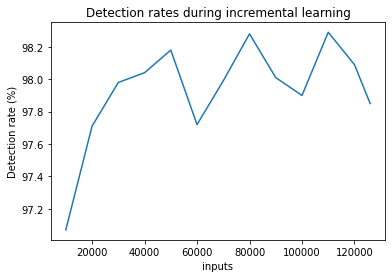

In [23]:
plt.plot(inputs, detection_rates, label='detection rate')
plt.title('Detection rates during incremental learning')
plt.xlabel('inputs')
plt.ylabel('Detection rate (%)')
plt.savefig('./test2_dr.png')
#plt.show()

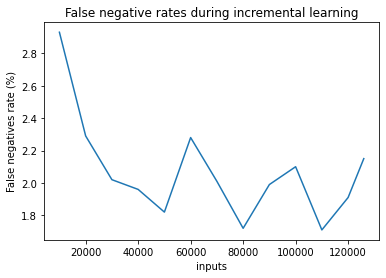

In [24]:
plt.plot(inputs, false_negatives, label='false negative rate')
plt.title('False negative rates during incremental learning')
plt.xlabel('inputs')
plt.ylabel('False negatives rate (%)')
plt.savefig('./test2_fnr.png')
#plt.show()

## Test #3: initial training on `train_normal` and `train_dos`, then incremental learning on `train_r2l`, `train_u2r`, and `train_probing` (Li-Ye)

In [31]:
# auxiliary function
def make_test(model, data, labels, title):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    tpr = 0
    fnr = 0
    accuracy = 0

    for index, row in data.iterrows():
        x = row.values
        y = labels[index]
        yp, _ = model.input_signal(x=x, learning=False)
        # feedback loop
        #if y != yp:
        #    model.input_signal(x=x, y=y, learning=True)

        # for metrics computation
        if yp != 'normal' and y != 'normal':
            tp += 1
        if yp != 'normal' and y == 'normal':
            fp += 1
        if yp == 'normal' and y == 'normal':
            tn += 1
        if yp == 'normal' and y != 'normal':
            fn += 1

    # metrics computation
    if (tp + fn) > 0:
        tpr = tp / (tp + fn)
    if (fn + tp) > 0:
        fnr = fn / (fn + tp)
    if (tp + tn + fp + fn) > 0:
        accuracy = (tp + tn) / (tp + tn + fp + fn)

    print(title)
    print(f'Accuracy (percentage of correctly predicted instances): {round(accuracy * 100, 2)}%')
    print(f'Detection Rate (TPR): {round(tpr * 100, 2)}%')
    print(f'False Negatives Rate (FNR - attacks classified as normal): {round(fnr * 100, 2)}%')

In [31]:
rand_int = random.randint(1, len(train_normal) - 1)
x1 = train_normal.iloc[rand_int].values
rand_int = random.randint(1, len(train_normal) - 1)
x2 = train_normal.iloc[rand_int].values
rand_int = random.randint(1, len(train_normal) - 1)
x3 = train_normal.iloc[rand_int].values

s = SF_SOINN.SF_SOINN(x1, x2, x3, max_edge_age=100, iter_lambda=100)

_, _, _, _, _ = train_phase(model=s, data=train_normal, labels=y_train_normal)

Training time: 2 min 55 sec
Inputs processed: 67342
Number of nodes: 273
Number of edges: 927


In [33]:
_, _, _, _, _ = train_phase(model=s, data=train_dos, labels=y_train_dos)

Training time: 3 min 51 sec
Inputs processed: 45926
Number of nodes: 569
Number of edges: 1437


In [34]:
make_test(model=s, data=test_normal, labels=y_test_normal, title="---------- normal ----------")
make_test(model=s, data=test_dos, labels=y_test_dos, title="---------- DOS ----------")
make_test(model=s, data=test_r2l, labels=y_test_r2l, title="---------- R2L ----------")
make_test(model=s, data=test_u2r, labels=y_test_u2r, title="---------- U2R ----------")
make_test(model=s, data=test_probing, labels=y_test_probing, title="---------- probing ----------")

---------- normal ----------
Accuracy (percentage of correctly predicted instances): 72.39%
Detection Rate (TPR): 0%
False Negatives Rate (FNR - attacks classified as normal): 0%
---------- DOS ----------
Accuracy (percentage of correctly predicted instances): 98.41%
Detection Rate (TPR): 98.41%
False Negatives Rate (FNR - attacks classified as normal): 1.59%
---------- R2L ----------
Accuracy (percentage of correctly predicted instances): 12.01%
Detection Rate (TPR): 12.01%
False Negatives Rate (FNR - attacks classified as normal): 87.99%
---------- U2R ----------
Accuracy (percentage of correctly predicted instances): 0.0%
Detection Rate (TPR): 0.0%
False Negatives Rate (FNR - attacks classified as normal): 100.0%
---------- probing ----------
Accuracy (percentage of correctly predicted instances): 62.75%
Detection Rate (TPR): 62.75%
False Negatives Rate (FNR - attacks classified as normal): 37.25%


In [35]:
_, _, _, _, _ = train_phase(model=s, data=train_r2l, labels=y_train_r2l)

Training time: 0 min 4 sec
Inputs processed: 994
Number of nodes: 578
Number of edges: 1420


In [36]:
make_test(model=s, data=test_normal, labels=y_test_normal, title="---------- normal ----------")
make_test(model=s, data=test_dos, labels=y_test_dos, title="---------- DOS ----------")
make_test(model=s, data=test_r2l, labels=y_test_r2l, title="---------- R2L ----------")
make_test(model=s, data=test_u2r, labels=y_test_u2r, title="---------- U2R ----------")
make_test(model=s, data=test_probing, labels=y_test_probing, title="---------- probing ----------")

---------- normal ----------
Accuracy (percentage of correctly predicted instances): 69.46%
Detection Rate (TPR): 0%
False Negatives Rate (FNR - attacks classified as normal): 0%
---------- DOS ----------
Accuracy (percentage of correctly predicted instances): 99.27%
Detection Rate (TPR): 99.27%
False Negatives Rate (FNR - attacks classified as normal): 0.73%
---------- R2L ----------
Accuracy (percentage of correctly predicted instances): 76.17%
Detection Rate (TPR): 76.17%
False Negatives Rate (FNR - attacks classified as normal): 23.83%
---------- U2R ----------
Accuracy (percentage of correctly predicted instances): 27.03%
Detection Rate (TPR): 27.03%
False Negatives Rate (FNR - attacks classified as normal): 72.97%
---------- probing ----------
Accuracy (percentage of correctly predicted instances): 70.25%
Detection Rate (TPR): 70.25%
False Negatives Rate (FNR - attacks classified as normal): 29.75%


In [38]:
_, _, _, _, _ = train_phase(model=s, data=train_u2r, labels=y_train_u2r)

Training time: 0 min 0 sec
Inputs processed: 51
Number of nodes: 598
Number of edges: 1428


In [38]:
make_test(model=s, data=test_normal, labels=y_test_normal, title="---------- normal ----------")
make_test(model=s, data=test_dos, labels=y_test_dos, title="---------- DOS ----------")
make_test(model=s, data=test_r2l, labels=y_test_r2l, title="---------- R2L ----------")
make_test(model=s, data=test_u2r, labels=y_test_u2r, title="---------- U2R ----------")
make_test(model=s, data=test_probing, labels=y_test_probing, title="---------- probing ----------")

---------- normal ----------
Accuracy (percentage of correctly predicted instances): 69.54%
Detection Rate (TPR): 0%
False Negatives Rate (FNR - attacks classified as normal): 0%
---------- DOS ----------
Accuracy (percentage of correctly predicted instances): 99.27%
Detection Rate (TPR): 99.27%
False Negatives Rate (FNR - attacks classified as normal): 0.73%
---------- R2L ----------
Accuracy (percentage of correctly predicted instances): 82.58%
Detection Rate (TPR): 82.58%
False Negatives Rate (FNR - attacks classified as normal): 17.42%
---------- U2R ----------
Accuracy (percentage of correctly predicted instances): 81.08%
Detection Rate (TPR): 81.08%
False Negatives Rate (FNR - attacks classified as normal): 18.92%
---------- probing ----------
Accuracy (percentage of correctly predicted instances): 69.26%
Detection Rate (TPR): 69.26%
False Negatives Rate (FNR - attacks classified as normal): 30.74%


In [40]:
_, _, _, _, _ = train_phase(model=s, data=train_probing, labels=y_train_probing)

Training time: 1 min 7 sec
Inputs processed: 11655
Number of nodes: 804
Number of edges: 1857


In [40]:
make_test(model=s, data=test_normal, labels=y_test_normal, title="---------- normal ----------")
make_test(model=s, data=test_dos, labels=y_test_dos, title="---------- DOS ----------")
make_test(model=s, data=test_r2l, labels=y_test_r2l, title="---------- R2L ----------")
make_test(model=s, data=test_u2r, labels=y_test_u2r, title="---------- U2R ----------")
make_test(model=s, data=test_probing, labels=y_test_probing, title="---------- probing ----------")

---------- normal ----------
Accuracy (percentage of correctly predicted instances): 64.48%
Detection Rate (TPR): 0%
False Negatives Rate (FNR - attacks classified as normal): 0%
---------- DOS ----------
Accuracy (percentage of correctly predicted instances): 99.74%
Detection Rate (TPR): 99.74%
False Negatives Rate (FNR - attacks classified as normal): 0.26%
---------- R2L ----------
Accuracy (percentage of correctly predicted instances): 76.31%
Detection Rate (TPR): 76.31%
False Negatives Rate (FNR - attacks classified as normal): 23.69%
---------- U2R ----------
Accuracy (percentage of correctly predicted instances): 70.27%
Detection Rate (TPR): 70.27%
False Negatives Rate (FNR - attacks classified as normal): 29.73%
---------- probing ----------
Accuracy (percentage of correctly predicted instances): 98.37%
Detection Rate (TPR): 98.37%
False Negatives Rate (FNR - attacks classified as normal): 1.63%


# Heatmaps of results from previous experiments

In [ ]:
import seaborn as sns

ads = ['10000', '5000', '1000', '500', '100']
lambdas = ['10', '50', '100', '500', '1000']

# experiments data
# rows are a_d (crescent - 100, 500, 1000, 5000, 10000)
# columns are lambda (crescent - 10, 50, 100, 500, 1000)

nodes = np.array([[307, 653, 901, 1621, 2502],
                [353, 587, 773, 791, 2470],
                [210, 601, 877, 1245, 2274],
                [383, 622, 653, 2009, 1929],
                [358, 642, 835, 2133, 2340]])

edges = np.array([[1456, 3557, 4535, 6856, 8570],
                [1962, 3756, 2934, 4091, 8343],
                [790, 2156, 4436, 6579, 7030],
                [1952, 2074, 3104, 7983, 6279],
                [1088, 2177, 3541, 7976, 6523]])

crs = np.array([[87.34, 92.12, 93.24, 93.98, 93.59],
                [88.70, 92.64, 93.03, 91.25, 93.93],
                [87.18, 91.09, 90.99, 93.11, 93.91],
                [89.19, 91.42, 91.87, 93.82, 91.22],
                [87.75, 92.50, 93.07, 94.15, 94.25]]) / 100

drs = np.array([[85.58, 93.18, 92.88, 93.49, 92.84],
                [87.95, 93.71, 93.81, 91.69, 93.64],
                [84.90, 93.24, 92.85, 93.81, 92.93],
                [88.06, 92.63, 93.95, 92.75, 91.22],
                [84.93, 93.24, 94.23, 93.20, 93.10]]) / 100

fprs = np.array([[10.33, 9.28, 7.60, 5.38, 5.42],
                [10.32, 8.77, 8.01, 9.33, 5.68],
                [9.80, 11.76, 11.48, 7.82, 4.80],
                [9.32, 10.18, 10.88, 4.76, 8.78],
                [8.52, 8.49, 8.47, 4.58, 4.21]]) / 100

fnrs = np.array([[14.42, 6.82, 6.12, 6.51, 7.16],
                [12.05, 6.29, 6.19, 8.31, 6.36],
                [15.10, 6.76, 7.15, 6.19, 7.07],
                [11.94, 7.37, 6.05, 7.25, 8.78],
                [15.07, 6.76, 5.77, 6.80, 6.90]]) / 100

cids = np.array([[45.82, 59.75, 63.97, 67.27, 65.88],
                [49.25, 61.63, 63.11, 56.90, 66.97],
                [45.65, 56.04, 55.72, 63.45, 67.28],
                [50.92, 57.27, 58.75, 67.00, 56.93],
                [47.63, 61.18, 63.19, 68.25, 68.83]]) / 100

# figure parameters
dpi = 120
width = 720/dpi
height = 480/dpi
# data
data = pd.DataFrame(nodes, columns=lambdas)
data['max edge age'] = ads
data = data.set_index('max edge age')
# plotting
plt.figure(figsize=(width, height), dpi=dpi)
plt.title('Network Nodes Heatmap')
sns.heatmap(data, cmap='coolwarm', annot=True, cbar=True, cbar_kws={'label': 'Nodes'}, fmt='.2%')
plt.xlabel('lambda')
#plt.show()
plt.savefig('./heat_nodes.png')

# Live phase example

In [177]:
rand_int = random.randint(1, len(test) - 1)
yp, confidence = live_phase(s, test.iloc[rand_int].values, teach=True)
print(f"Output: {yp}")
print(f"Confidence: {round(confidence * 100, 2)}%")
print(f"Correct output {y_test[rand_int]}")

Output: normal
Confidence: 94.25%
Correct output normal
